## Using a phase shift for generating a Hadamard gate

$$\renewcommand{\ket}[1]{\left|{#1}\right\rangle}$$
$$\renewcommand{\bra}[1]{\left\langle{#1}\right|}$$
$$\renewcommand{\braket}[2]{\left\langle{#1}\middle|{#2}\right\rangle}$$

In this tutorial, we will put two qubits in superposition using a Hadamard gate. The Hadamard gate can be generated using a phase shift, as shown below:

$H=U(\frac{\pi}{2},\frac{\pi}{2}, \frac{\pi}{ 2}) = R_Z(\pi) U(-\frac{\pi}{2},\frac{\pi}{2},\frac{\pi}{2}),$

where $U$ is a general rotation around $x$ and $z$. For more information, one can check the following [pulser tutorial](https://pulser.readthedocs.io/en/stable/tutorials/phase_shifts_vz_gates.html)

In [2]:
# import libraries
import pulser
from pulser.devices import AnalogDevice
from pulser.waveforms import BlackmanWaveform
import numpy as np

from emu_mps import MPS, MPSConfig, MPSBackend, BitStrings, Fidelity

import matplotlib.pyplot as plt
from matplotlib.pyplot import pcolormesh

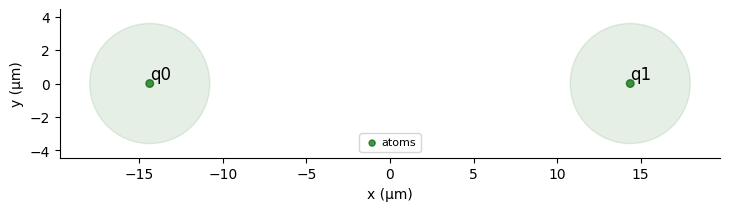

In [3]:
# register: we are going to crate 2 qubits far from each other to decrease the interaction term
U = 2 * np.pi  # fixing the interation energy
n_qubits = 2
R_interaction = AnalogDevice.rydberg_blockade_radius(U)
reg = pulser.Register.rectangle(1, n_qubits, spacing=4.0 * R_interaction, prefix="q")
reg.draw(blockade_radius=R_interaction, draw_graph=True, draw_half_radius=True)

In [4]:
# sequence and pulse cration
#
seq = pulser.Sequence(reg, AnalogDevice)
seq.declare_channel("ising_global", "rydberg_global", initial_target="q0")

pi2_wf = BlackmanWaveform(1000, np.pi / 2)
pi_2 = pulser.Pulse.ConstantDetuning(pi2_wf, detuning=0, phase=np.pi / 2)
seq.add(pi_2, "ising_global")  # pi/2-pulse

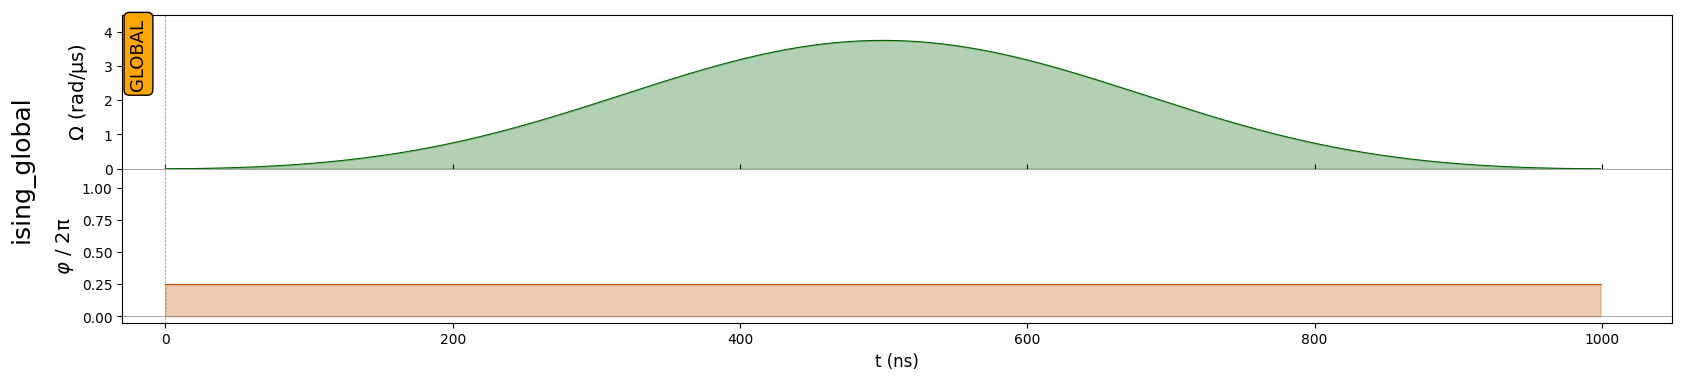

In [5]:
# plot the sequence with the added phase
seq.draw("input", draw_phase_curve=True, draw_phase_shifts=True)

In [6]:
# printing the sequence, one can see the phase value
# negative values are added 2pi
print(seq)

Channel: ising_global
t: 0 | Initial targets: q0, q1 | Phase Reference: 0.0 
t: 0->1000 | Pulse(Amp=Blackman(Area: 1.57) rad/µs, Detuning=0 rad/µs, Phase=1.57) | Targets: q0, q1




In [7]:
# initialize a Backend instance
sim = MPSBackend()

In [8]:
# Configuration for the Backend and for observables
dt = 50  # time step for discretization, by the default: dt =10

# information for the observables

final_time = seq.get_duration() // dt * dt
# Calculate the final time of the sequence. Some observables will be measured at time steps
# that are multiples of dt.  Using integer division // ensures time steps align with dt.
# NOTE: The sequence is discretized by dt, so the state evolves at these time steps.

times = [final_time]  # final step for an observable to be measure
# all the times have to be a multiple of dt


# fidelity against the evolved state

basis = {
    "r",
    "g",
}  # basis that the observables are going to be measured.
# At the moment, we are only accepting the rydberg basis

nqubits = len(seq.register.qubit_ids)  # for the observables

ground_state = {"g" * n_qubits: 1}  # \gg> state

ground_mps_state = MPS.from_state_string(
    basis=basis, nqubits=nqubits, strings=ground_state
)

In [9]:
## observables, instantiate the observables

bitstrings = BitStrings(evaluation_times=times, num_shots=1000)
fidelity_ground = Fidelity(evaluation_times=times, state=ground_mps_state)

In [10]:
# we give the configuration of the backend and the observables
mpsconfig = MPSConfig(
    dt=dt,
    observables=[bitstrings, fidelity_ground],
)

In [11]:
# running the sequence with the run method
results = sim.run(seq, mpsconfig)

step = 1/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.029 s
step = 2/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 3/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 4/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 5/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 6/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 7/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 8/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 9/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 10/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 11/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 12/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 13/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 14/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 15/20, χ = 1, |ψ| = 0.000 MB, RSS = 9.058 MB, Δt = 0.003 s
step = 16/20, χ = 1

In [12]:
# all the computed observables
results.get_result_names()

['bitstrings', 'fidelity_0']

In [13]:
# bitstrings at a given time
bitstrings_final = results[bitstrings.name()][final_time]  # get the bitstring

In [14]:
max_val = max(bitstrings_final.values())  # max number of counts in the bitstring
print("Max count value: ", max_val)
max_string = [key for key, value in bitstrings_final.items() if value == max_val]
print("Bitstring with the max number of counts: ", max_string)

Max count value:  262
Bitstring with the max number of counts:  ['10']


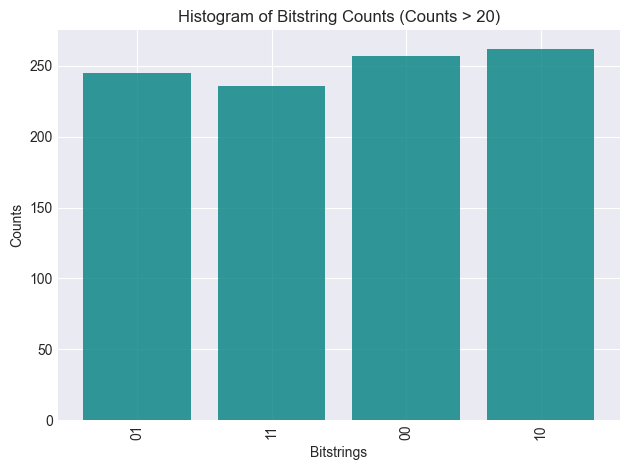

In [15]:
# plot the histogram with counts greater than 20
filtered_counts = [count for count in bitstrings_final.values() if count > 20]
filtered_bitstrings = [
    bitstring for bitstring, count in bitstrings_final.items() if count > 20
]
x_labels = range(len(filtered_bitstrings))

with plt.style.context("seaborn-darkgrid"):
    fig, ax = plt.subplots()
    ax.bar(x_labels, filtered_counts, color="teal", alpha=0.8)
    ax.set_xlabel("Bitstrings")
    ax.set_ylabel("Counts")
    ax.set_title("Histogram of Bitstring Counts (Counts > 20)")
    ax.set_xticks(x_labels)
    ax.set_xticklabels(filtered_bitstrings, rotation="vertical")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig("save_bitstring-10.png")
    plt.show()

In [16]:
# fidelity respect to the final state
final_fidelity = results[fidelity_ground.name()][
    final_time
]  # if you run another time the tutorial will generate another fidelity

print("fidelity between the final state and the ground state by the user")
print(final_fidelity)

print("\nThe probability of being in the ground state")
print(abs(final_fidelity) ** 2)  #  it is related to the bitstrings

fidelity between the final state and the ground state by the user
(0.5000013699526465+8.754124484896384e-05j)

The probability of being in the ground state
0.2500013776179929


In [17]:
# emu_mps version
import emu_mps

emu_mps.__version__

'0.2.0'